# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

## Arquitecturas

La primera idea que podemos probar es utilizar una `CNN` que no reduzca las dimensiones de los diferentes mapas de características, utilizando la correcta configuración de filtros y sin usar `pooling`. 

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)

Este tipo de arquitectura, sin embargo, no será capaz de extraer características a diferentes escalas y además será computacionalmente muy costos. Podemos aliviar estos problemas utilizando una arquitectura `encoder-decoder`, en la que en una primera etapa una `CNN` extrae características a diferentes escalas y luego otra `CNN` recupera las dimensiones originales.

![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)

Para poder utilizar este tipo de arquitecturas necesitamos alguna forma de incrementar la dimensión de un mapa de características. De entre las diferentes opciones, una muy utilizada es el uso de `convoluciones traspuestas`, una capa muy parecida a la capa convolucional que "aprende" la mejor forma de aumentar un mapa de características aplicando filtros que aumentan la resolución.

![](https://miro.medium.com/max/1972/1*kOThnLR8Fge_AJcHrkR3dg.gif)

Puedes aprender más sobre esta operación en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) de `Pytorch`. De esta manera podemos diseñar arquitecturas más eficientes capaces de extraer información relevante a varias escalas. Sin embargo, puede ser un poco complicado recuperar información en el `decoder` simplemente a partir de la salida del `encoder`. Para resolver este problema se desarrolló una de las arquitecturas más conocidas y utilizadas para la segmentación: la red `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

Esta arquitectura es muy similar a la anterior, con la diferencia de que en cada etapa del `decoder` no solo entra la salida de la capa anterior sino también la salida de la capa correspondiente del `encoder`. De esta manera la red es capaz de aprovechar mucho mejor la información a las diferentes escalas.

Vamos a ver cómo implementar esta arquitectura para hacer segmentación de MRIs.

## El Dataset

Podemos descargar un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación usando el siguiente enlace.

Nuestro objetivo será el de segmentar una MRI cerebral para detectar la materia gris y blanca. Determinar la cantidad de ambas así como su evolución en el tiempo para un mismo paciente es clave para la detección temprana y tratamiento de enfermedades como el alzheimer. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pycocotools.coco import COCO
from PIL import Image, ImageOps
!ls

drive  sample_data


In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import json

# Leer los archivos JSON originales
with open('/content/drive/MyDrive/JsonSegmentacion/bolsa_annotations.coco.json', 'r') as file:
    json_data_1 = json.load(file)

with open('/content/drive/MyDrive/JsonSegmentacion/papel_annotations.coco.json', 'r') as file:
    json_data_2 = json.load(file)

# Crear un nuevo objeto JSON vacío
json_combined = {}

# Copiar los campos iniciales
json_combined['info'] = json_data_1['info']
json_combined['licenses'] = json_data_1['licenses']
json_combined['categories'] = json_data_1['categories']

# Combinar las imágenes y anotaciones
json_combined['images'] = json_data_1['images'] + json_data_2['images']
json_combined['annotations'] = json_data_1['annotations'] + json_data_2['annotations']

# Guardar el nuevo objeto JSON en un archivo
with open('archivo_combinado.json', 'w') as file:
    json.dump(json_combined, file)


In [5]:
cocofile= open("/content/archivo_combinado.json")
plastoformos = json.load(cocofile)
plastoformos['categories'][0],plastoformos['images'][0], plastoformos['annotations'][0]

({'id': 0, 'name': 'bolsa', 'supercategory': 'none'},
 {'id': 0,
  'license': 1,
  'file_name': '0182_jpg.rf.fedb3b37a9f695534c28eaffb1a57a00.jpg',
  'height': 600,
  'width': 800,
  'date_captured': '2023-06-02T13:29:01+00:00'},
 {'id': 0,
  'image_id': 0,
  'category_id': 1,
  'bbox': [309, 302, 210, 129.5],
  'area': 27195,
  'segmentation': [[395.5,
    402,
    431.5,
    401,
    489.5,
    381,
    504,
    319.5,
    519,
    305.5,
    470.5,
    302,
    411.5,
    306,
    355.5,
    317,
    332.5,
    308,
    314,
    338.5,
    309,
    430.5,
    334,
    431.5,
    374.5,
    419,
    395.5,
    402]],
  'iscrowd': 0})

In [6]:
image_id=10
coco_data=COCO("/content/archivo_combinado.json")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [7]:
img = coco_data.imgs[image_id]
img

{'id': 10,
 'license': 1,
 'file_name': 'papel-933-_jpg.rf.0251c00719007f15e02b951e3ce75784.jpg',
 'height': 600,
 'width': 800,
 'date_captured': '2023-06-02T12:52:51+00:00'}

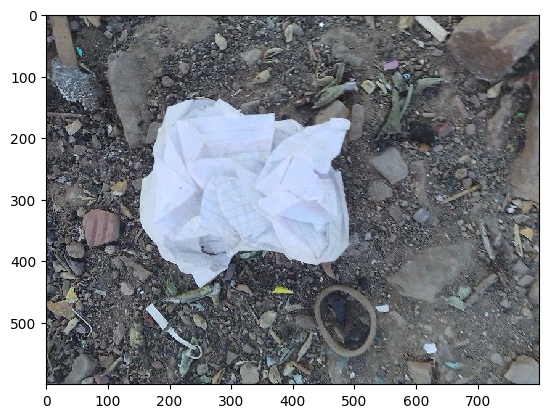

In [8]:
image = np.array(Image.open("/content/drive/MyDrive/DatasetSegmentacionJson/"+img['file_name']).convert('RGB'))
plt.imshow(image, interpolation='nearest')
plt.show()

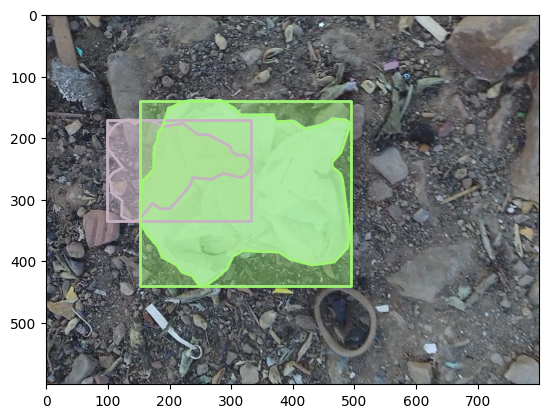

In [9]:
plt.imshow(image)
cat_ids = coco_data.getCatIds()
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco_data.loadAnns(anns_ids)
coco_data.showAnns(anns,draw_bbox=True)

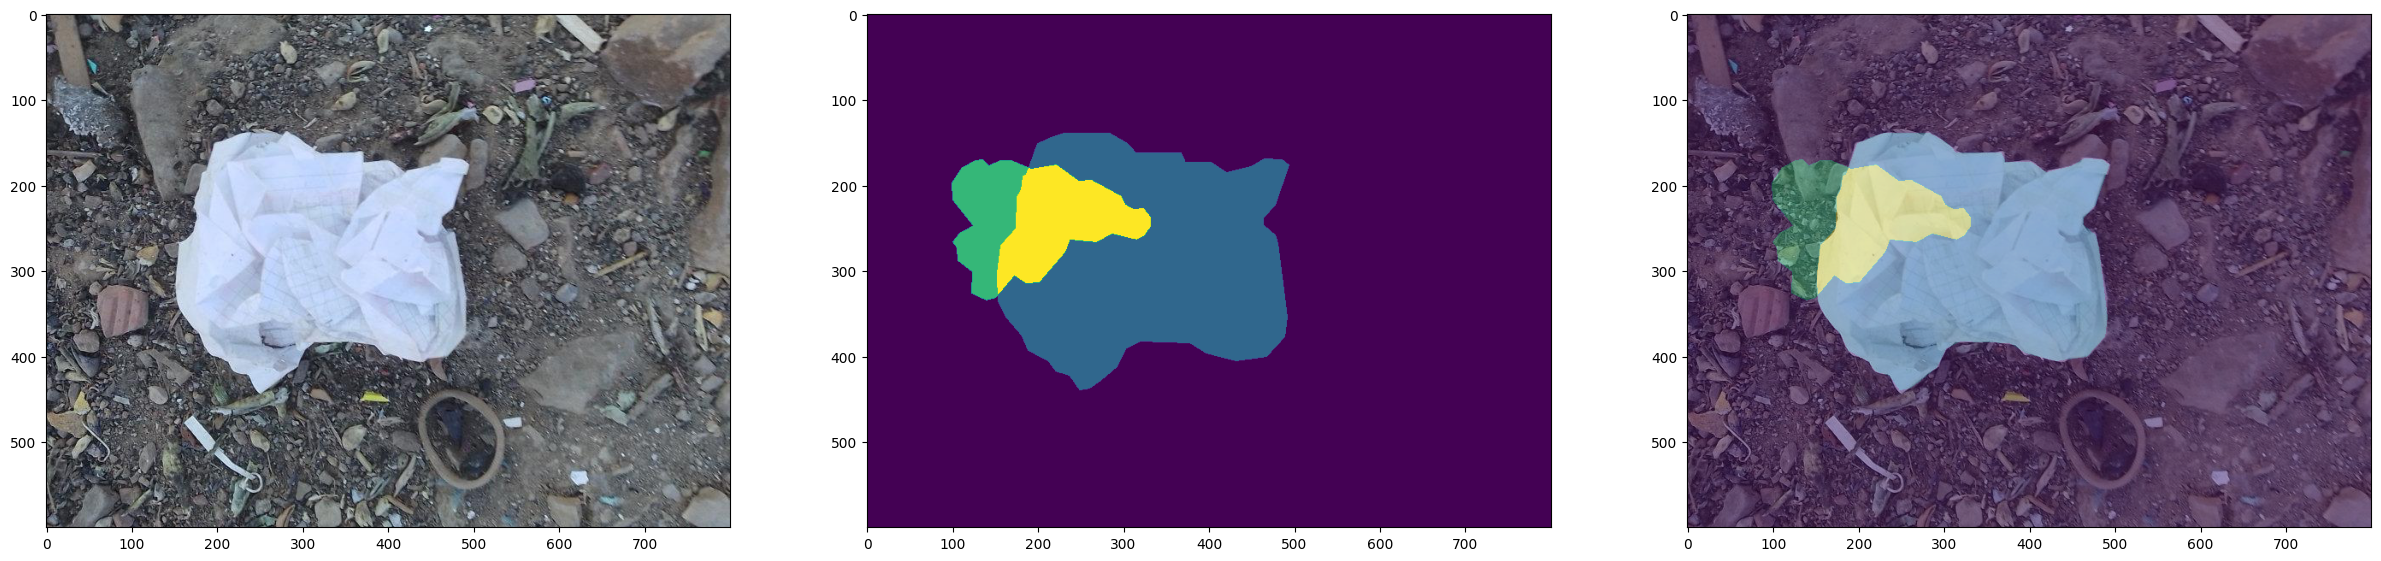

In [10]:
mask = coco_data.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco_data.annToMask(anns[i])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(image)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [11]:
from random import sample
def loadImages(dataset_coco, split=0.1):
    img_test_ = []
    img_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = dataset_coco.anns
    test_ids = sample([x for x in range(0,len(coco_data.anns))],int(len(coco_data.anns)*split))
    for i in data_:
        image_id_ = data_[i]['image_id']
        img_ = coco_data.imgs[image_id_]
        image_path="/content/drive/MyDrive/DatasetSegmentacionJson/"+img_['file_name']
        image_load_ = Image.open(image_path).convert('RGB')
        image_ = np.array(image_load_)/255
        anns_=dataset_coco.loadAnns(data_[i]['id'])
        mask_ = dataset_coco.annToMask(anns_[0])
        for ian in range(len(anns_)):
            mask_ += dataset_coco.annToMask(anns_[ian])
        if(i not in test_ids):
            img_train_.append(image_path)
            labels_train_.append(mask_)
        else:
            img_test_.append(image_path)
            labels_test_.append(mask_)
    return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)

In [12]:
img_train, img_test, labels_train, labels_test = loadImages(coco_data, split=0.1)

In [13]:
img_train.shape

(1637,)

In [14]:
img_train[0], img_test[0], labels_train[0].shape, labels_test[0].shape

('/content/drive/MyDrive/DatasetSegmentacionJson/papel-651-_jpg.rf.0084c3b6b55ed35ef169f9dccdf678d9.jpg',
 '/content/drive/MyDrive/DatasetSegmentacionJson/papel-446-_jpg.rf.010a57d2ce0d8b6e73495db85f11af88.jpg',
 (600, 800),
 (600, 800))

In [15]:
import albumentations as A
from skimage import io
from skimage import color
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=3, transform=None):
        self.X = X
        self.y = y
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        #image_load = Image.open(self.X[ix]).convert('RGB')
        img = io.imread(self.X[ix])
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
        image = np.array(img) / 255
        img = image.astype(np.float32)

        mask = self.y[ix]
        img = torch.from_numpy(img).permute(2, 0, 1)
        mask = (np.arange(self.n_classes) == mask[..., None]).astype(np.float32)

        if self.transform is not None:
            img = img.permute(1, 2, 0).numpy()  # Convertir de nuevo a NumPy
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            img = torch.from_numpy(img).permute(2, 0, 1)

        return img, torch.from_numpy(mask).permute(2, 0, 1)

In [16]:
trans = A.Compose([
    A.Resize(224, 224)
])
dataset = {
    'train': Dataset(img_train, labels_train, transform=trans),
    'test': Dataset(img_test, labels_test, transform=trans)
}

len(dataset['train']), len(dataset['test'])

(1637, 181)

In [17]:
dataset['train'][0]

(tensor([[[0.3996, 0.3973, 0.5212,  ..., 0.2586, 0.3684, 0.4656],
          [0.5254, 0.5885, 0.5896,  ..., 0.3422, 0.5541, 0.4913],
          [0.5554, 0.5621, 0.6867,  ..., 0.4261, 0.1909, 0.2973],
          ...,
          [0.5184, 0.5054, 0.4254,  ..., 0.6154, 0.6574, 0.7205],
          [0.6660, 0.7103, 0.6822,  ..., 0.3504, 0.6451, 0.6462],
          [0.5487, 0.5033, 0.3769,  ..., 0.2091, 0.6138, 0.6339]],
 
         [[0.3918, 0.3828, 0.5022,  ..., 0.2530, 0.3684, 0.4695],
          [0.5176, 0.5740, 0.5705,  ..., 0.3355, 0.5524, 0.4927],
          [0.5476, 0.5476, 0.6677,  ..., 0.4104, 0.1792, 0.2878],
          ...,
          [0.4400, 0.4348, 0.3591,  ..., 0.5566, 0.6058, 0.6672],
          [0.5836, 0.6378, 0.6148,  ..., 0.2916, 0.5936, 0.5930],
          [0.4624, 0.4282, 0.3063,  ..., 0.1503, 0.5623, 0.5807]],
 
         [[0.3957, 0.3867, 0.5078,  ..., 0.1875, 0.2653, 0.3431],
          [0.5215, 0.5779, 0.5761,  ..., 0.2752, 0.4629, 0.3800],
          [0.5515, 0.5515, 0.6733,  ...,

In [18]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=5, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=10, pin_memory=True)
}
imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 224, 224]), torch.Size([5, 3, 224, 224]))

In [19]:
imgs[0]

tensor([[[0.6427, 0.6061, 0.6204,  ..., 0.5777, 0.5453, 0.5626],
         [0.6177, 0.5720, 0.5790,  ..., 0.5966, 0.5480, 0.5704],
         [0.5948, 0.5628, 0.5565,  ..., 0.5769, 0.5817, 0.6172],
         ...,
         [0.5388, 0.5341, 0.5289,  ..., 0.3310, 0.3303, 0.3377],
         [0.5385, 0.5467, 0.5059,  ..., 0.2736, 0.3497, 0.3344],
         [0.5208, 0.4843, 0.5106,  ..., 0.3810, 0.4101, 0.4566]],

        [[0.6034, 0.5703, 0.5851,  ..., 0.5620, 0.5296, 0.5469],
         [0.5785, 0.5362, 0.5437,  ..., 0.5810, 0.5324, 0.5548],
         [0.5556, 0.5269, 0.5212,  ..., 0.5613, 0.5660, 0.6016],
         ...,
         [0.5388, 0.5341, 0.5250,  ..., 0.3114, 0.3068, 0.3024],
         [0.5385, 0.5467, 0.5020,  ..., 0.2540, 0.3262, 0.2991],
         [0.5208, 0.4843, 0.5067,  ..., 0.3614, 0.3866, 0.4213]],

        [[0.5956, 0.5524, 0.5576,  ..., 0.5660, 0.5335, 0.5509],
         [0.5707, 0.5183, 0.5162,  ..., 0.5849, 0.5363, 0.5587],
         [0.5477, 0.5090, 0.4938,  ..., 0.5652, 0.5699, 0.

In [20]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [21]:
import torchvision
import torch

In [22]:
# encoder = torchvision.models.resnet18(pretrained=True)
# encoder
# encoder = torchvision.models.googlenet(pretrained=True)
# encoder

encoder = torchvision.models.vgg.vgg16(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:16<00:00, 32.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [24]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, kernel_size=4, stride=2, padding=1)
        self.conv1 = conv3x3_bn(ci + co, co)
        self.conv2 = conv3x3_bn(co, co)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (0, diffY, 0, diffX))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [25]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1):
        super().__init__()

        self.encoder = torchvision.models.vgg.vgg16(pretrained=True)
        if in_ch != 3:
            self.encoder.features[0] = torch.nn.Conv2d(
                in_ch, 64, kernel_size=3, stride=1, padding=1, bias=False
            )

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.features[:4](x)
        # print("X: ",x.shape)
        x1 = self.encoder.features[5:10](x)
        # print("X1: ",x1.shape)
        x2 = self.encoder.features[10:17](x1)
        # print("X2: ",x2.shape)
        x3 = self.encoder.features[17:24](x2)
        # print("X3: ",x3.shape)
        x = self.encoder.features[24:](x3)
        # print("X: ",x.shape)
        x = self.deconv1(x, x3)
        # print("X Deconv: ",x.shape)
        x = self.deconv2(x, x2)
        # print("X Deconv: ",x.shape)
        x = self.deconv3(x, x1)
        # print("X Deconv: ",x.shape)
        x = self.out(x, x_in)
        # print("X Deconv: ",x.shape)
        return x

In [26]:
model = UNetResnet(in_ch=3)
# output = model(torch.randn((5,1,394,394)))
# output.shape

In [28]:
hist = fit(model, dataloader, epochs=10)

  0%|          | 0/328 [00:00<?, ?it/s]<ipython-input-25-0dca32de9b5e>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.05719 test_iou 0.97776: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]



Epoch 1/10 loss 0.05826 iou 0.97641 test_loss 0.05719 test_iou 0.97776


test_loss 0.05078 test_iou 0.97777: 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]



Epoch 2/10 loss 0.05557 iou 0.97706 test_loss 0.05078 test_iou 0.97777


test_loss 0.05218 test_iou 0.97720: 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]



Epoch 3/10 loss 0.05429 iou 0.97719 test_loss 0.05218 test_iou 0.97720


test_loss 0.04944 test_iou 0.97879: 100%|██████████| 19/19 [00:08<00:00,  2.18it/s]



Epoch 4/10 loss 0.05335 iou 0.97800 test_loss 0.04944 test_iou 0.97879


test_loss 0.05617 test_iou 0.97931: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]



Epoch 5/10 loss 0.05267 iou 0.97836 test_loss 0.05617 test_iou 0.97931


test_loss 0.05553 test_iou 0.97884: 100%|██████████| 19/19 [00:09<00:00,  2.09it/s]



Epoch 6/10 loss 0.05236 iou 0.97851 test_loss 0.05553 test_iou 0.97884


test_loss 0.04979 test_iou 0.97894: 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]



Epoch 7/10 loss 0.05130 iou 0.97954 test_loss 0.04979 test_iou 0.97894


test_loss 0.05050 test_iou 0.97798: 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]



Epoch 8/10 loss 0.05215 iou 0.97942 test_loss 0.05050 test_iou 0.97798


test_loss 0.04987 test_iou 0.97762: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]



Epoch 9/10 loss 0.04953 iou 0.98038 test_loss 0.04987 test_iou 0.97762


test_loss 0.05052 test_iou 0.97895: 100%|██████████| 19/19 [00:09<00:00,  2.05it/s]


Epoch 10/10 loss 0.04815 iou 0.98142 test_loss 0.05052 test_iou 0.97895


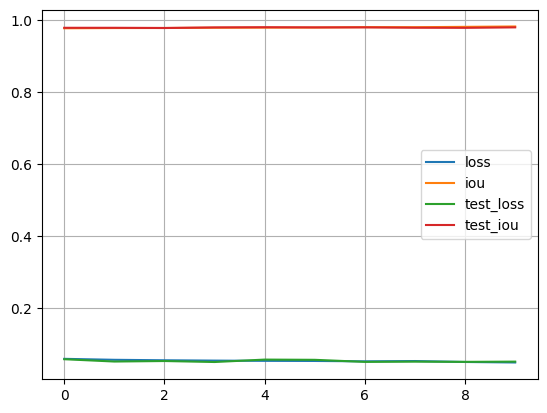

In [29]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

<ipython-input-25-0dca32de9b5e>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


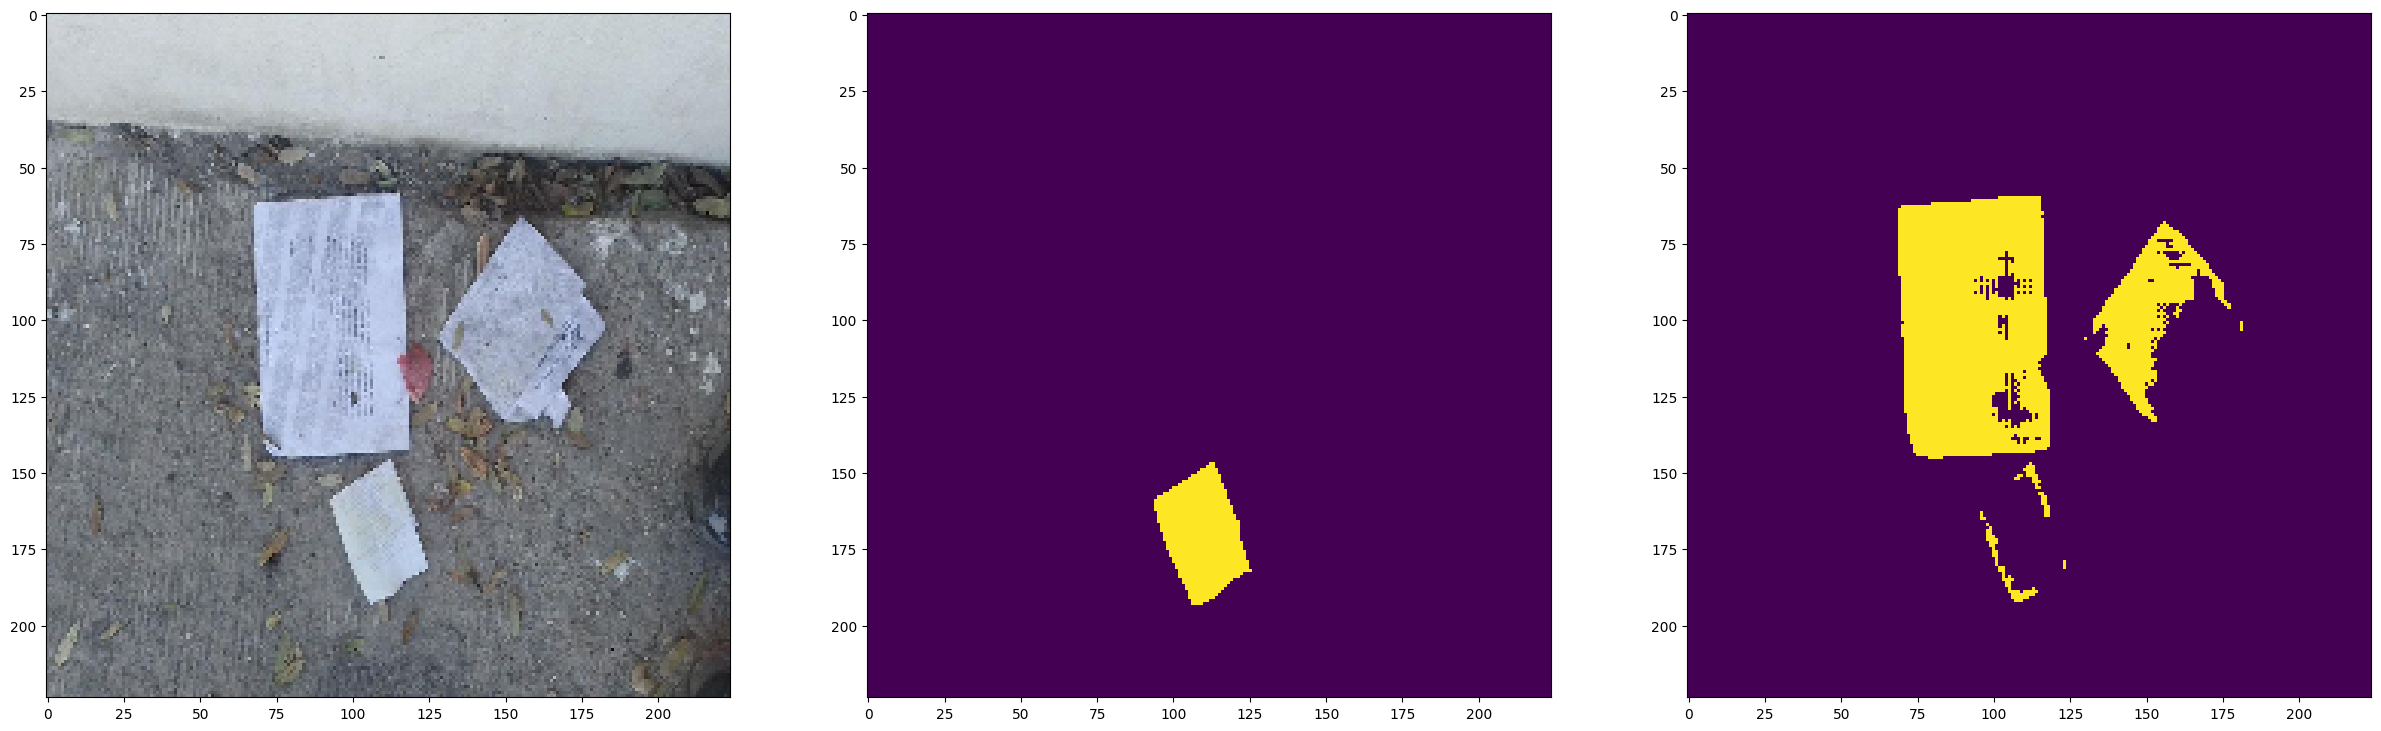

In [41]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [37]:
PATH = './UNetVGG.pt'
torch.save(model.state_dict(), PATH)